# Hajbi et al.

### define process data function

In [9]:
def compare_brine_concentrations(dataframe, raw_data, export_path, literature_cf, original_concentrations = True):
    from chempy.properties.water_density_tanaka_2001 import water_density
    from sigfig import round
    from scipy.constants import milli, kilo
    from chemicals import periodic_table
    from matplotlib import pyplot
    import matplotlib

#     pandas.set_option('display.max_columns', None)
#     pandas.set_option('display.max_rows', None)
#     print('raw_data')
#     display(raw_data)
#     print('processed_data')
#     display(dataframe)

    
    # final effluent concentrations
    final_cf = raw_data['mass_H2O'].iloc[0] / raw_data['mass_H2O'].iloc[-1]
    last_row = dataframe.iloc[-1]
    print('literature_cf', literature_cf)
    print('final_cf', final_cf)

    # feed concentrations
    water_density = water_density()/kilo
    custom_water_parameters = {
        'element': {
            'Ca': {
                'concentration (ppm)':720,
                'reference': ''
            },
            'Mg': {
                'concentration (ppm)':335,
                'reference':''
            },
            'Na': {
                'concentration (ppm)':1950,
                'reference':''
            },
            'Sr': {
                'concentration (ppm)':13,
                'reference':''
            },
            'Cl': {
                'concentration (ppm)':3550,
                'reference':''
            },
            'S(6)': {
                'concentration (ppm)':2250,
                'reference':''
            },
            'Fe': {
                'concentration (ppm)':0.2,
                'reference':''
            }
        }
    }


    elemental_masses = {}
    for element in periodic_table:
        elemental_masses[element.symbol] = element.MW
    
    def make_molal(elements):
        molals = {}
        for element in elements:
            original_element = element
            element = re.sub('(?:\(\d\))', '', element)
            mass = elemental_masses[element]/milli
            if type(elements[original_element]) is dict:
                ppm_conc = elements[original_element]['concentration (ppm)']
            else:
                ppm_conc = elements[original_element]
            molal_conc = ppm_conc / water_density / mass
            molals[original_element] = float(molal_conc)
            
        return molals

    molals = make_molal(custom_water_parameters['element'])
    literature_molals = make_molal(literature_final_conc)

    # final effluent CF for each element
    cfs = {}
    diff_list = []
    labels = []
    for element, final_conc in last_row.iteritems():
        element = re.search('([A-Z][a-z]?(?:\(\d\))?(?=\(mol\/kgw\)))', element).group()
        cfs[element] = {}
        initial_conc = molals[element]

        if original_concentrations:
            if element in literature_elemental_cfs:
                cfs[element]['cf'] = float(final_conc) / initial_conc
                diff = ((cfs[element]['cf'] - literature_elemental_cfs[element]) / literature_elemental_cfs[element]) * 100
                labels.append(element)
                diff_list.append(diff)
                cfs[element]['% diff'] = diff
                
        elif not original_concentrations:
            if element in literature_final_conc:
                predicted_conc = float(ross.predicted_effluent[element])
                literature_conc = float(literature_final_conc[element])
                print(predicted_conc, literature_conc)
                diff = ((predicted_conc - literature_conc) / literature_conc) * 100
                labels.append(element)
                diff_list.append(diff)
                cfs[element]['% diff'] = diff

    # define a bar graph of CF error 
    print(cfs)
    labels.append('CF')
    total_cf_error = ((final_cf - literature_cf) / literature_cf * 100)
    diff_list.append(total_cf_error)
    min_diff = min(diff_list) - 5
    max_diff = max(diff_list) + 5

    pyplot.rcParams['figure.figsize'] = (12, 9)
    pyplot.rcParams['figure.dpi'] = 100
    figure, ax = pyplot.subplots()
    bar_graph = ax.bar(labels, diff_list)
    ax.axhline(0, color='grey', linewidth=0.8)
    ax.set_ylabel('relative % difference')
    ax.set_ylim(min_diff, max_diff)
    ax.set_xlabel('Element')
    ax.set_title('Elemental difference of ROSSpy from Hajbi et al.')
    diff_list = [round(value, 2, notation = 'sci') for value in diff_list]
    ax.bar_label(bar_graph, diff_list)
    figure.savefig(export_path)

### Experimental conditions

In [10]:
from scipy.constants import nano, milli, day, hour
import os

# run the ROSS model
%run ../../../rosspy/core.py
# ross = ROSSPkg()
# import rosspy
# ross = rosspy.ROSSPkg(verbose = False)

def average(some_list):
    return sum(some_list)/ len(some_list)

# module parameters
quantity_of_modules = 5
module_characteristics = {        
    'permeate_flow_m3_per_day': {
        'value':1200 / quantity_of_modules,
    },
    'max_feed_flow_m3_per_hour': {
        'value':1848 / (day/hour),
    }
}

# water parameters
solution_description = 'Hajbi'
water_characteristics = {
    'element': {
        'Ca': {
            'concentration (ppm)':720,
            'reference': ''
        },
        'Mg': {
            'concentration (ppm)':335,
            'reference':''
        },
        'Na': {
            'concentration (ppm)':1950,
            'reference':''
        },
        'Sr': {
            'concentration (ppm)':13,
            'reference':''
        },
        'Cl': {
            'concentration (ppm)':3550,
            'reference':''
        },
        'S(6)': {
            'concentration (ppm)':2250,
            'reference':''
        },
        'Fe': {
            'concentration (ppm)':0.2,
            'reference':''
        }
    }
}

# literature final effluent concentrations 
literature_final_conc = {
    'Ca': 2080,
    'Mg': 770,
    'Na': 5120,
    'Cl': 14170,
    'S(6)': 5920
}
literature_elemental_cfs = {}
for element in literature_final_conc:
    true_element = re.search('([A-Z][a-z]?)', element).group()
    literature_elemental_cfs[element] = literature_final_conc[element]/(water_characteristics['element'][element]['concentration (ppm)'])
literature_cf = average([literature_final_conc[element]/water_characteristics['element'][element]['concentration (ppm)'] for element in literature_final_conc])

# general parameters
database_selection = 'pitzer'
simulation_title = 'test'
simulation = 'brine'

## Execute multiple modules through all_time


Estimated completion in 6.04 seconds: 2022-01-21 00:35:05.667952 local time.
run_time (s): 21.838009100000022
literature_cf 2.8871395568204483
final_cf 2.8796381727678697
{'Ca': {'cf': 1.4189485462313078, '% diff': -50.88255032276242}, 'Mg': {'cf': 2.8966781512183792, '% diff': 26.02430917638403}, 'Na': {'cf': 2.8966743712622742, '% diff': 10.322559061746773}, 'Sr': {}, 'Cl': {'cf': 2.8966781512148594, '% diff': -27.42972874514643}, 'S(6)': {'cf': 0.5855518184092096, '% diff': -77.74507446924459}, 'Fe': {}}


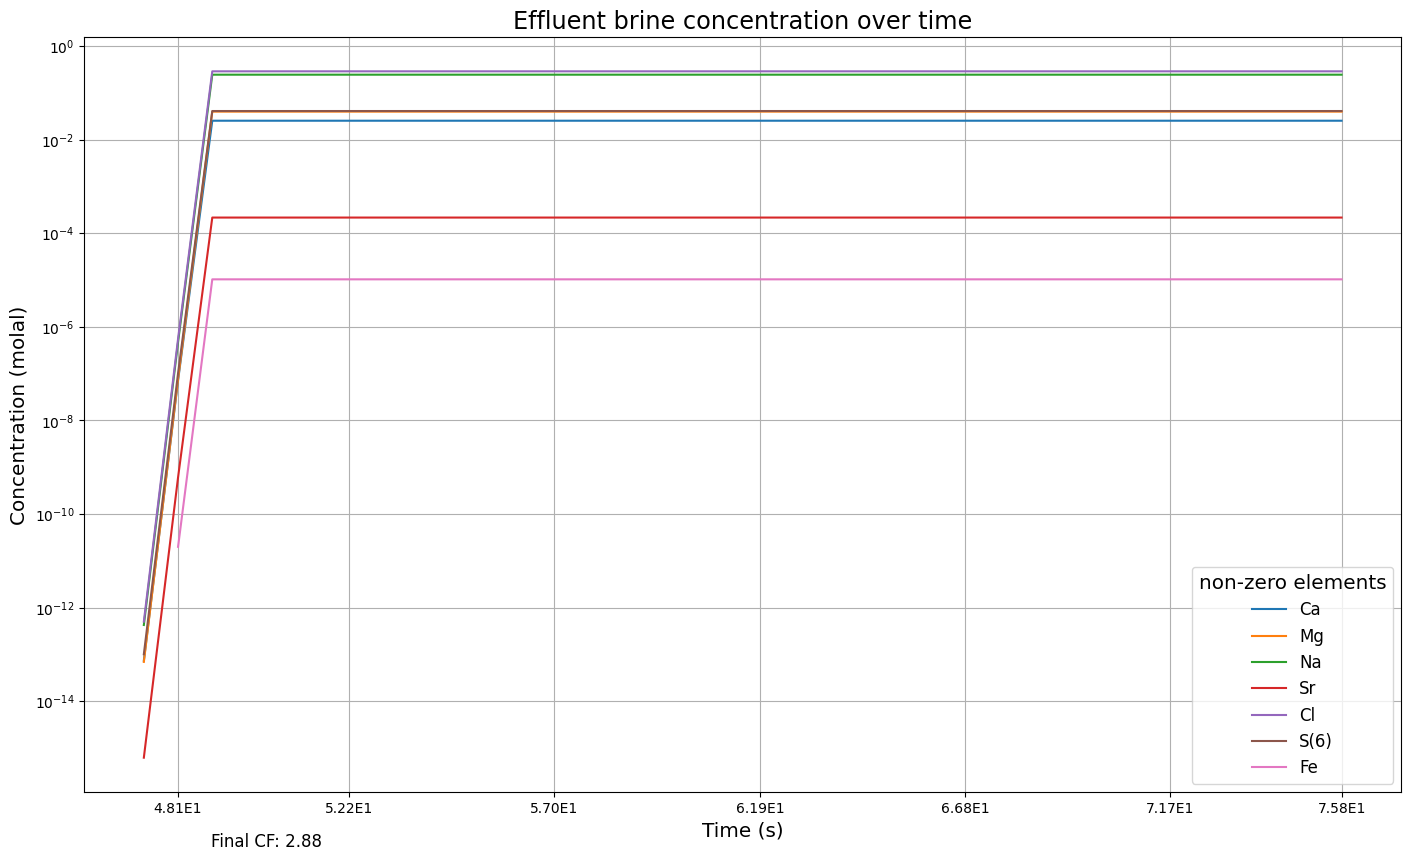

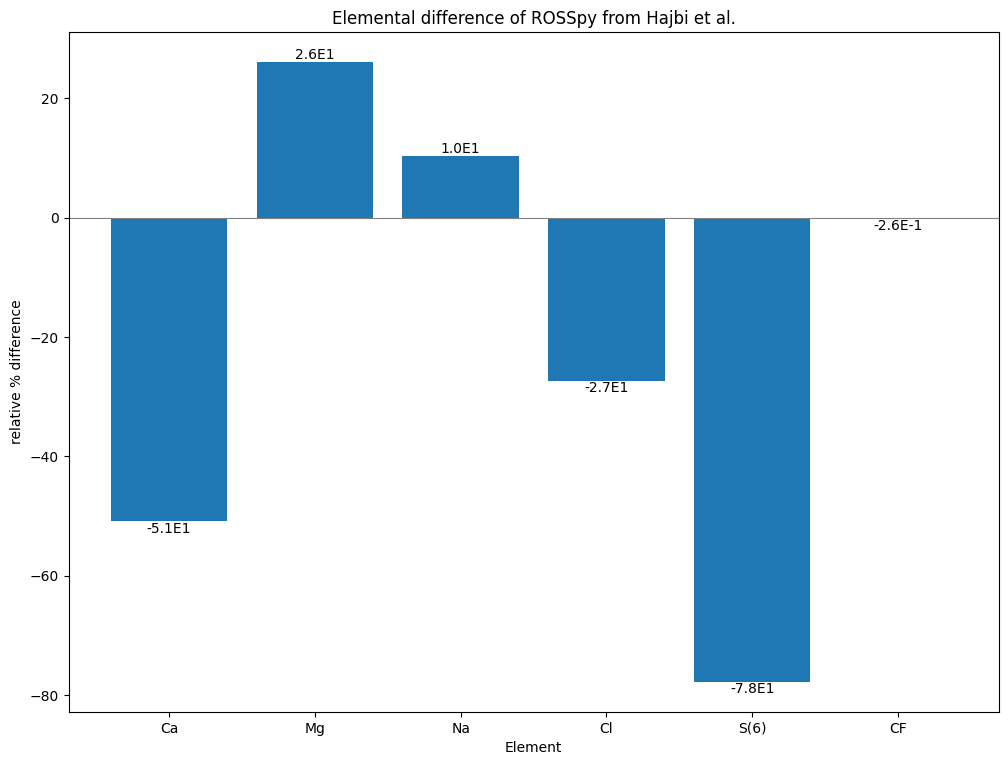

In [11]:
simulation_perspective = 'all_time'
simulation_name = 'multiple_modules'
simulation_time = 75

# create the input file
%run ../../../rosspy/ro.py
ross = ROSSPkg(database_selection, simulation, quantity_of_modules = quantity_of_modules, printing = False)
ross.reactive_transport(simulation_time, simulation_perspective, literature_cf, module_characteristics)
ross.feed_geochemistry('', water_characteristics, solution_description)
ross.execute(simulation_name)

# process and export the data
export_path = os.path.join(ross.simulation_path, 'Hajbi_comparison.png')
compare_brine_concentrations(ross.processed_data, ross.selected_output, export_path, literature_cf)

# Execute multiple modules through all_time, with improvements


Estimated completion in 34.1 seconds: 2022-01-21 00:47:06.567515 local time.
run_time (s): 56.370206699999926
literature_cf 2.8871395568204483
final_cf 2.8796381727678595
2078.7404809107225 2080.0
967.19175153485 770.0
5629.922135799873 5120.0
10249.34542671259 14170.0
6496.0640028460075 5920.0
{'Ca': {'% diff': -0.0605538023691128}, 'Mg': {'% diff': 25.609318381149354}, 'Na': {'% diff': 9.959416714841272}, 'Sr': {}, 'Cl': {'% diff': -27.66869847062392}, 'S(6)': {'% diff': 9.730810858885262}, 'Fe': {}}


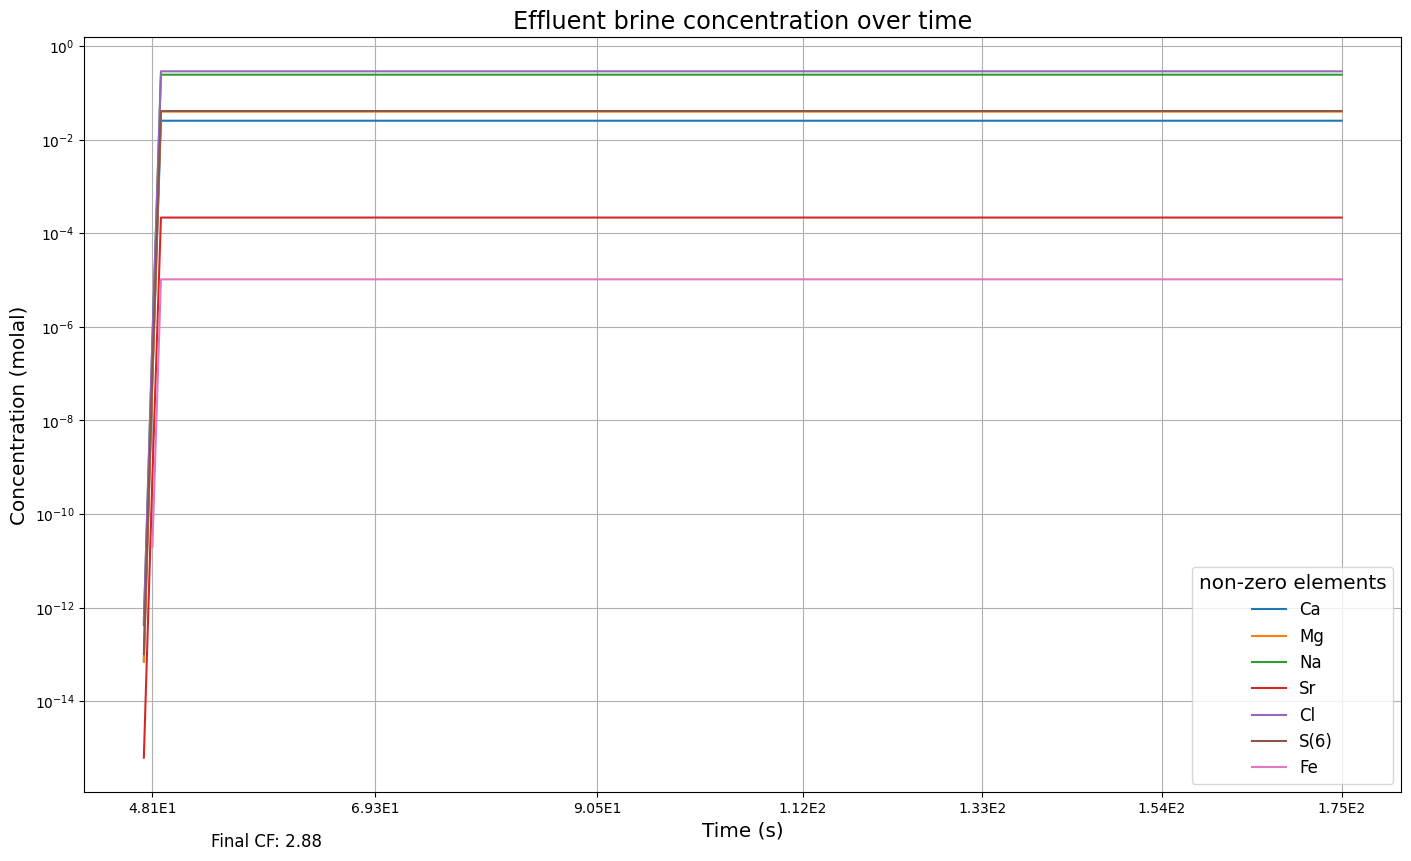

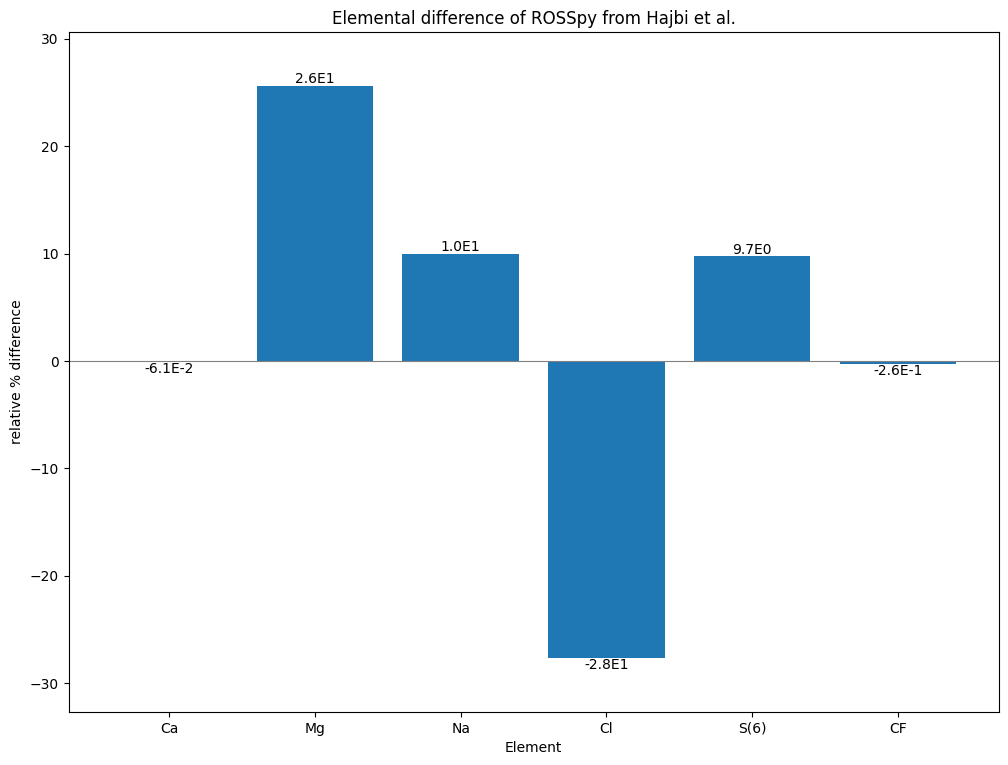

In [16]:
simulation_perspective = 'all_time'
simulation_time = 175
simulation_name = 'improved_multiple_modules'

# create the input file
%run ../../../rosspy/ro.py
ross = ROSSPkg(database_selection, simulation, quantity_of_modules = quantity_of_modules, printing = False)
ross.reactive_transport(simulation_time, simulation_perspective, literature_cf, module_characteristics)
ross.feed_geochemistry('', water_characteristics, solution_description)
ross.execute(simulation_name)

# process and export the data
export_path = os.path.join(ross.simulation_path, 'Hajbi_comparison.png')
compare_brine_concentrations(ross.processed_data, ross.selected_output, export_path, literature_cf, False)

## Execute a single module over all_time


Estimated completion in 26.0 seconds: 2022-01-21 00:42:41.002147 local time.
run_time (s): 21.860685999999987
literature_cf 2.8871395568204483
final_cf 2.8796381727678697
2078.7404809107225 2080.0
967.19175153485 770.0
5629.922135799873 5120.0
10249.34542671259 14170.0
6496.0640028460075 5920.0
{'Ca': {'% diff': -0.0605538023691128}, 'Mg': {'% diff': 25.609318381149354}, 'Na': {'% diff': 9.959416714841272}, 'Sr': {}, 'Cl': {'% diff': -27.66869847062392}, 'S(6)': {'% diff': 9.730810858885262}, 'Fe': {}}


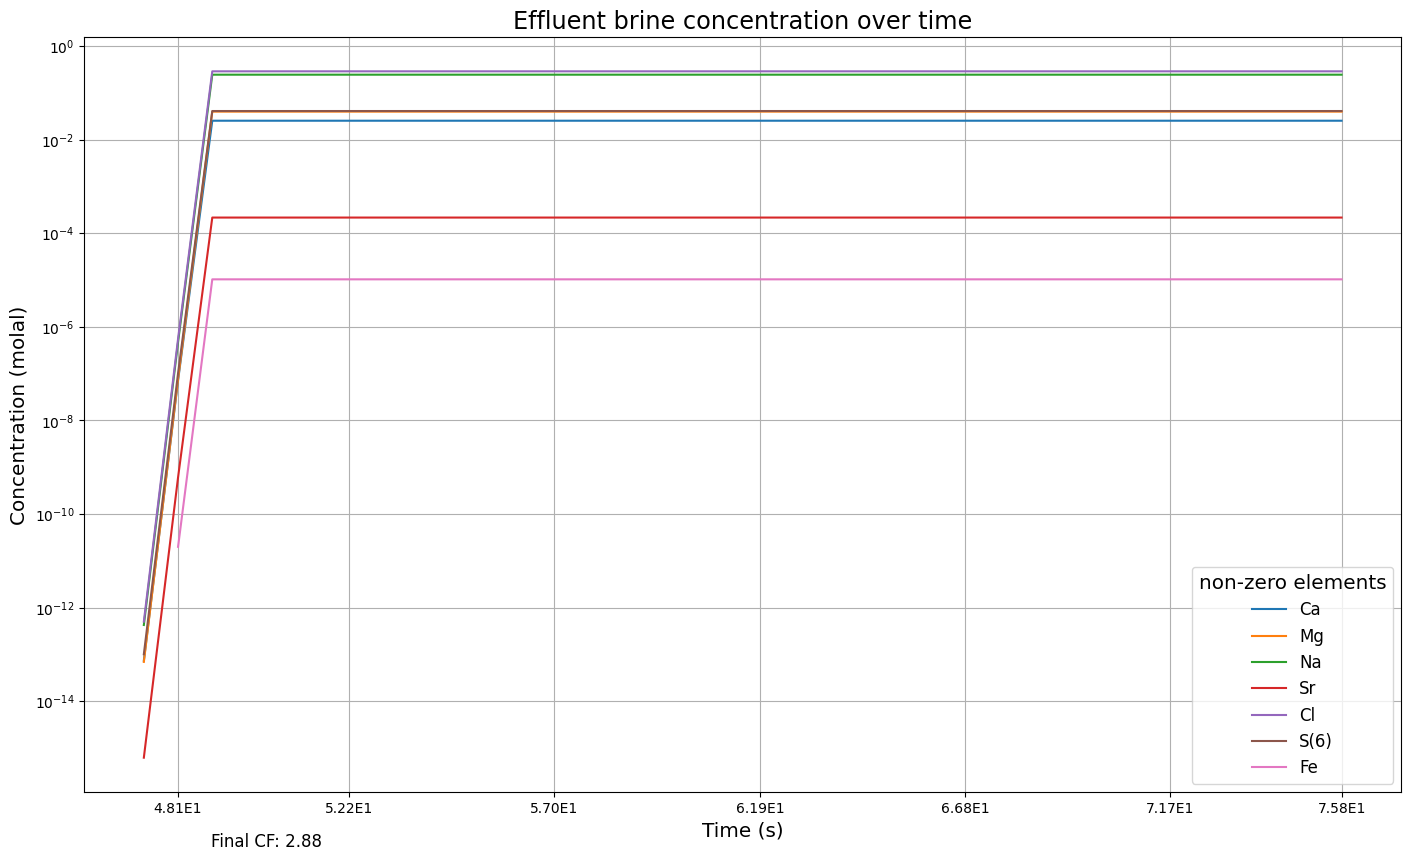

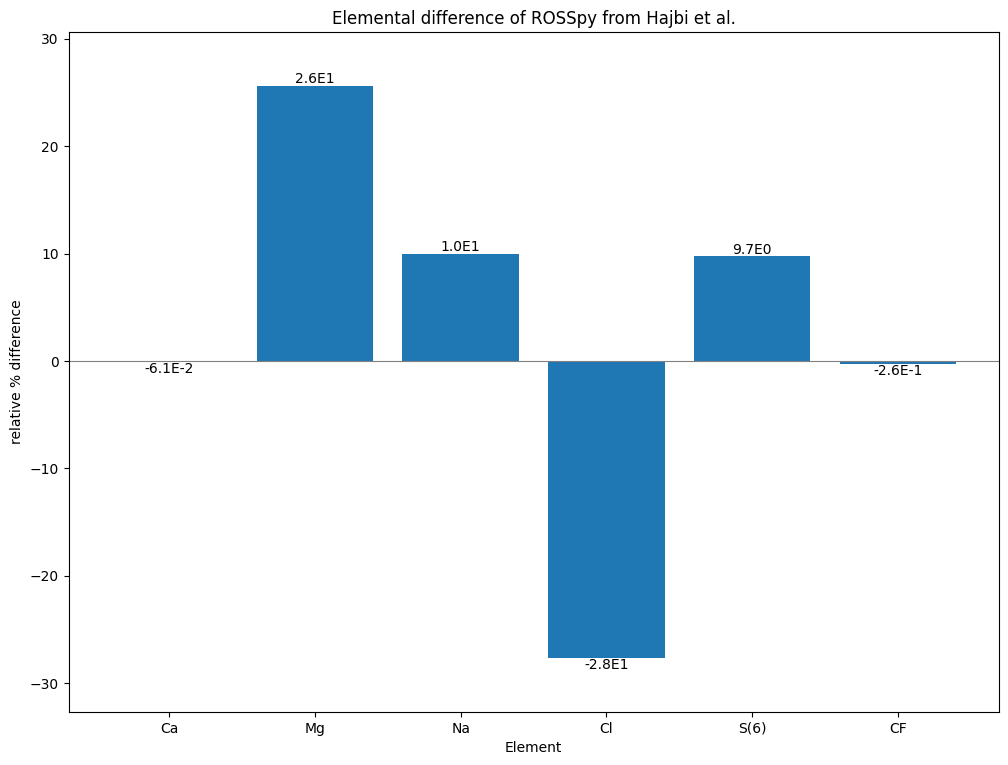

In [15]:
simulation_perspective = 'all_time'
simulation_time = 75
simulation_name = 'improved_single_module'

# create the input file
%run ../../../rosspy/ro.py
ross = ROSSPkg(database_selection, simulation, quantity_of_modules = quantity_of_modules, printing = False)
ross.reactive_transport(simulation_time, simulation_perspective, literature_cf, module_characteristics)
ross.feed_geochemistry('', water_characteristics, solution_description)
ross.execute(simulation_name)

# process and export the data
export_path = os.path.join(ross.simulation_path, 'Hajbi_comparison.png')
compare_brine_concentrations(ross.processed_data, ross.selected_output, export_path, literature_cf, False)

## Execute a single module over all_distance


Estimated completion in 26.0 seconds: 2022-01-21 00:37:10.520311 local time.
run_time (s): 21.86946469999998
literature_cf 2.8871395568204483
final_cf 2.8796381727678697
2078.7404809107225 2080.0
967.19175153485 770.0
5629.922135799873 5120.0
10249.34542671259 14170.0
6496.0640028460075 5920.0
{'Ca': {'% diff': -0.0605538023691128}, 'Mg': {'% diff': 25.609318381149354}, 'Na': {'% diff': 9.959416714841272}, 'Sr': {}, 'Cl': {'% diff': -27.66869847062392}, 'S(6)': {'% diff': 9.730810858885262}, 'Fe': {}}


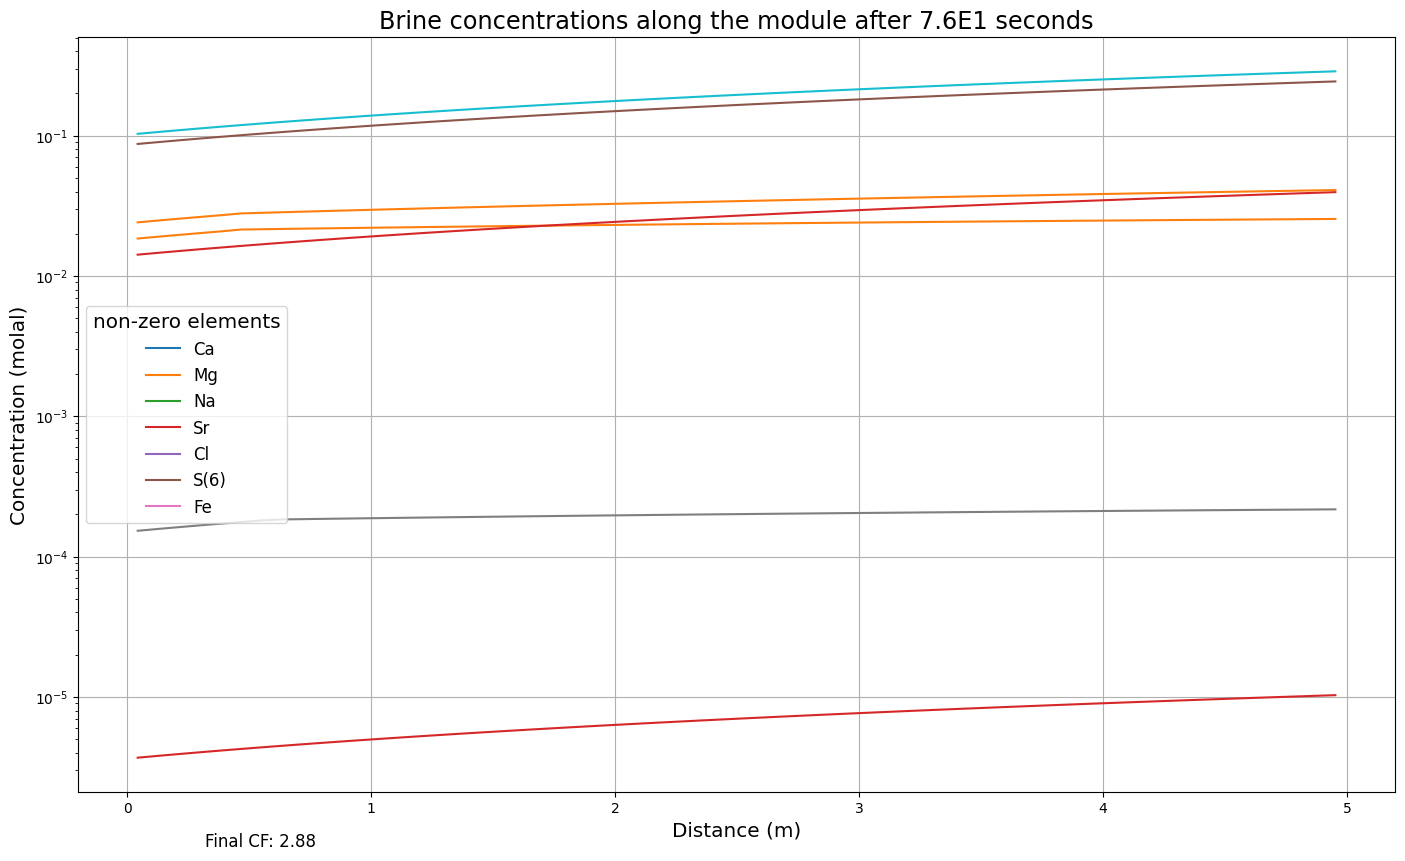

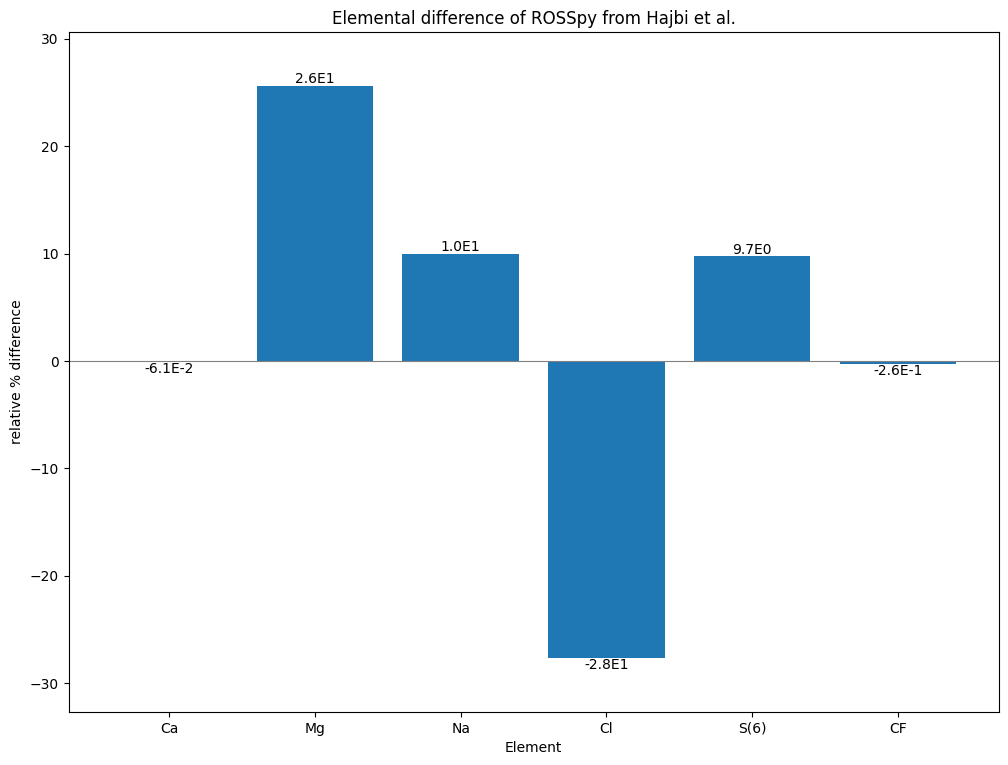

In [14]:
simulation_perspective = 'all_distance'
simulation_time = 75
simulation_name = 'improved_single_module_over_distance'

# create the input file
%run ../../../rosspy/ro.py
ross = ROSSPkg(database_selection, simulation, quantity_of_modules = quantity_of_modules, printing = False)
ross.reactive_transport(simulation_time, simulation_perspective, literature_cf, module_characteristics)
ross.feed_geochemistry('', water_characteristics, solution_description)
ross.execute(simulation_name)

# process and export the data
export_path = os.path.join(ross.simulation_path, 'Hajbi_comparison.png')
compare_brine_concentrations(ross.processed_data, ross.selected_output, export_path, literature_cf, False)